# Gutzwiller state on a quantum computer

Here I will generalize the Gutzwiller approach so that the lattice can be fed into the functions instead of making a new notebook for each lattice.  The rest of the procedure will be based on the notebook "Triangular_Lattice_Local_Givens_Alpha_Circs"

# Initialize operators and fucntion

Below I define the identiry operator $I$, the Pauli operators $X$, $Y$, and $Z$, fermion creations and analiation operators $c^{\dagger}$, $c$, and the fermion number operator $n=c^{\dagger}c$.

I also define a function Mdot to take the dot product of multiple operators and btk to take brakets of operators.

In [65]:
import qiskit.quantum_info as qi
import scipy as sp
import numpy as np
import pandas as pd
import math
import scipy.linalg as ln
import copy

def I(N):
    label = ['I' for i in range(N)]
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def X(i,N):
    label = ['I' for i in range(N)]
    label[N-1-i] = 'X'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Y(i,N):
    label = ['I' for i in range(N)]
    label[N-1-i] = 'Y'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Z(i,N):
    label = ['I' for i in range(N)]
    label[N-1-i] = 'Z'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def c(i,N):
    label_1 = ['Z' for j in range(N-i-1)]
    label_2 = ['I' for j in range(N-i,N)]
    label_x = label_1 + ['X'] + label_2
    label_y = label_1 + ['Y'] + label_2
    label_x = ''.join(label_x)
    label_y = ''.join(label_y)
    x = qi.Operator.from_label(label_x).data
    y = qi.Operator.from_label(label_y).data
    return 1/2*(x+1j*y)

def cd(i,N):
    label_1 = ['Z' for j in range(N-i-1)]
    label_2 = ['I' for j in range(N-i,N)]
    label_x = label_1 + ['X'] + label_2
    label_y = label_1 + ['Y'] + label_2
    label_x = ''.join(label_x)
    label_y = ''.join(label_y)
    x = qi.Operator.from_label(label_x).data
    y = qi.Operator.from_label(label_y).data
    return 1/2*(x-1j*y)

def n(i,N):
    return Mdot([cd(i,N),c(i,N)])


import numpy as np


def Mdot(Ol):
    L = len(Ol)
    out = Ol[L-1]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[L-1-i],out)
    return out

def bkt(y1,O,y2):
    return Mdot([np.conjugate(y1),O,y2])

# Define the system

The system is defined by its Hemiltonian which is composed of three parts.  A Kinetic term
$$ \hat{K} = k \sum_{i\sigma} \left( c^{\dagger}_{i\sigma}c_{i+1\sigma} + c^{\dagger}_{i+1\sigma}c_{i\sigma} \right)$$
an interaction term
$$ \hat{D} = \sum_i \hat{n}_{i,\uparrow}\hat{n}_{i,\downarrow}.  $$
and a chemical potential
$$ \hat{M} = \mu \sum_{i\sigma}  c^{\dagger}_{i\sigma}c_{i\sigma} $$

I also define the Gutzwiler operator,
$$ \hat{G} = \prod_{i=0}^{N-1}e^{-g n_{i\uparrow}n_{i\downarrow}} = \prod_{i=0}^{N-1} (1 - n_{i\uparrow}n_{i\downarrow} (e^{-g}-1) ), $$
and the lowest energy two partcle eigenstate of $\hat{K}$
$$ |\psi_1> = a^{\dagger}_0a^{\dagger}_1|0>. $$
and 
$$ |\psi_{\text{spin}}> = |\psi_1>\otimes|\psi_1> $$
such that $\hat{K}|\psi_{\text{spin}}> = E_{01}|\psi_{\text{spin}}>$

In [66]:
def G(g,N):
    out = I(2*N)
    for i in range(N):
        out = Mdot([ out , I(2*N) + (np.exp(-g)-1)*Mdot([n(i,2*N),n(i+N,2*N)]) ])
    return out

def K_triag(k):
    Kout = 0*I(8)
    Kout = Kout + Mdot([cd(0,8),c(1,8)]) + Mdot([cd(0,8),c(2,8)])+ Mdot([cd(0,8),c(3,8)])
    Kout = Kout + Mdot([cd(1,8),c(0,8)]) + Mdot([cd(1,8),c(2,8)])+ Mdot([cd(1,8),c(3,8)])
    Kout = Kout + Mdot([cd(2,8),c(0,8)]) + Mdot([cd(2,8),c(1,8)])+ Mdot([cd(2,8),c(3,8)])
    Kout = Kout + Mdot([cd(3,8),c(0,8)]) + Mdot([cd(3,8),c(1,8)])+ Mdot([cd(3,8),c(2,8)])
    N=4
    Kout = Kout + Mdot([cd(N+0,8),c(N+1,8)]) + Mdot([cd(N+0,8),c(N+2,8)])+ Mdot([cd(N+0,8),c(N+3,8)])
    Kout = Kout + Mdot([cd(N+1,8),c(N+0,8)]) + Mdot([cd(N+1,8),c(N+2,8)])+ Mdot([cd(N+1,8),c(N+3,8)])
    Kout = Kout + Mdot([cd(N+2,8),c(N+0,8)]) + Mdot([cd(N+2,8),c(N+1,8)])+ Mdot([cd(N+2,8),c(N+3,8)])
    Kout = Kout + Mdot([cd(N+3,8),c(N+0,8)]) + Mdot([cd(N+3,8),c(N+1,8)])+ Mdot([cd(N+3,8),c(N+2,8)])
    return k*Kout

def K_square(k,N):
    Kout = 0*I(2*N)
    for i in range(0,N-1):
        Kout = Kout + Mdot([cd(i,2*N),c(i+1,2*N)]) + Mdot([cd(i+1,2*N),c(i,2*N)])
        Kout = Kout + Mdot([cd(i+N,2*N),c(i+1+N,2*N)]) + Mdot([cd(i+1+N,2*N),c(i+N,2*N)])
    Kout = Kout + Mdot([cd(0,2*N),c(N-1,2*N)]) + Mdot([cd(N-1,2*N),c(0,2*N)])
    Kout = Kout + Mdot([cd(0+N,2*N),c(N-1+N,2*N)]) + Mdot([cd(N-1+N,2*N),c(0+N,2*N)])
    return k*Kout

def K(k,lattice,N=None):
    if lattice == "square":
        return K_square(k,N)
    if lattice == "triangle":
        return K_triag(k)

def D(d,N):
    Dout = 0*I(2*N)
    for i in range(0,N):
        Dout = Dout + Mdot([n(i,2*N),n(i+N,2*N)])
    return d*Dout

def M(u,N):
    Dout = 0*I(2*N)
    for i in range(0,N):
        Dout = Dout + n(i,2*N) 
        Dout = Dout + n(i+N,2*N)
    return u*Dout

def psi0(N):
    y = [0 for i in range(2**N)]
    y[0] = 1
    return y


# Defining the circuit representation of the slatter determinent

This is described in detail in 'Gutzwiller_In_KSpace'.

First we need the transformation function $f$ such that 
$$ a^{\dagger}_n = \sum_i f_{in} c^{\dagger}_i $$
or if we group the creation operators into a vector 
$$ \vec{a}^{\dagger} = \hat{F} \vec{c}^{\dagger} $$

In [67]:
def K_single_triag(k):
    h = [[0 for i in range(4)] for ii in range(4)]
    h[0][1] = -k; h[0][2] = -k; h[0][3] = -k;
    h[1][0] = -k; h[1][2] = -k; h[1][3] = -k;
    h[2][0] = -k; h[2][1] = -k; h[2][3] = -k;
    h[3][0] = -k; h[3][1] = -k; h[3][2] = -k;
    return h

def K_single_square(k,N):
    h = [[0 for i in range(N)] for ii in range(N)]
    for i in range(0,N-1):
        h[i][i+1] = -k
        h[i+1][i] = -k 
    h[N-1][0] = -k
    h[0][N-1] = -k

    return h

def K_single(k,lattice,N=None):
    if lattice == "square":
        return K_single_square(k,N)
    if lattice == "triangle":
        return K_single_triag(k)

In [68]:
def Fl(lattice, N=None):
    e,y = ln.eigh(K_single(1,lattice,N=N))
    return np.transpose(y)
    
def Fld(lattice, N=None):
    e,y = ln.eigh(K_single(1,lattice,N=N))
    return np.conjugate(y)

N=4
lattice = 'square'
pd.DataFrame( Mdot([Fl(lattice,N),K_single(2,lattice,N),Fld(lattice,N)]) )

,0,1,2,3
0,-4.000000e+00,0.0,-4.678717e-15,1.221245e-15
1,-9.197389e-17,0.0,1.972152e-31,0.000000e+00
2,-4.781849e-15,0.0,-4.801561e-30,-1.473497e-15
3,1.443290e-15,0.0,-1.538532e-15,4.000000e+00


In [69]:
def ad(n,F):
    N = len(F)
    Fd = np.conjugate(np.transpose(F))
    out = Fd[0][n]*cd(0,N)
    for i in range(1,N):
        out = out + Fd[i][n]*cd(i,N)
    return out

def a(n,F):
    N = len(F)
    Fd = np.conjugate(np.transpose(F))
    out = F[n][0]*c(0,N)
    for i in range(1,N):
        out = out + F[n][i]*c(i,N)
    return out

In [70]:
N=4
lattice = 'square'
#lattice = 'triangle'
F = Fl(lattice,N)
psi1 = Mdot([ad(3,F),ad(2,F),psi0(4)])
psi_spin = np.kron(psi1,psi1)

k=1.3
np.amax(np.abs( Mdot([K(k,lattice,N),psi_spin]) - Mdot([np.conjugate(psi_spin),K(k,lattice,N),psi_spin])*psi_spin ))

3.1086244689504383e-15

The stratagy is then to find rotations which diagonalize $\hat{F}$ then we can apply the reverse rotations to create $\hat{F}$ on the quantum computer.  I should make it clear that we are talking about two different spaces.  The single particle space where $\hat{F}$ acts and the manybody space in which the quantum computer lives.  Since the state we want to create has a representation in both spaces, we can map between them.  We will do the following rotations in the single particle space,

$$ (r^y_{ij}(\phi))_{kl} = \cos(\phi)\delta_{ik}\delta_{il}+\cos(\phi)\delta_{jk}\delta_{jl} + \sin(\phi)\delta_{ik}\delta_{jl} - \sin(\phi)\delta_{jk}\delta_{il}$$
and 
$$ (r^z_j(\phi))_{kl} = e^{i\phi}\delta_{ik}\delta_{kl} $$

these are combined in the 'givens' function below.  We preform the a number of givens rotations until $\hat{F}$ is diagonalized.  This gives us the correct angles for the rotations.  Then we map these rotations to the manybody space.  $r^z$ maps simply to an $R^z$ rotation in the many body space while $r^y$ maps to the function $R_{cc}$ defined below. 
$$ r^z \rightarrow R^z $$
$$ r^y \rightarrow R_{cc}$$

$G_{cc}$ combines both manybody rotations and 'fswap' is a fermion swap which is nececcary for $R_{cc}$

As in the previous notebook we only perform Givens rotations on neihboring qubits so that we avoid fermion swap gates.

In [71]:
def ry(i,j,phi,N):
    M = (1+0*1j)*np.identity(N)
    M[i,i] = np.cos(phi)
    M[j,j] = np.cos(phi)
    M[i,j] = np.sin(phi)
    M[j,i] = -np.sin(phi)
    return M


def rz(j,phi,N):
    M = (1+0*1j)*np.identity(N)
    M[j,j] = np.exp(1j*phi)
    return M


from qiskit import QuantumCircuit

def fswap(i,j,qc):
    qc.swap(i,j)
    qc.ry(np.pi/2,j)
    qc.cx(i,j)
    qc.ry(-np.pi/2,j)
    return qc
    

def R_cc(i,j,phi,qc):
    for l in range(i+1,j):
        qc = fswap(l-1,l,qc)
    qc.ry(-np.pi/2,j-1)
    qc.cx(j-1,j)
    qc.ry(-phi,j)
    qc.cx(j-1,j)
    qc.ry(np.pi/2,j-1)
    qc.ry(-np.pi/2,j)
    qc.cx(j,j-1)
    qc.ry(phi,j-1)
    qc.cx(j,j-1)
    qc.ry(np.pi/2,j)
    for l in range(j-1,i+1-1,-1):
        qc = fswap(l-1,l,qc)
    return qc

def G_cc(i,j,phi,phiz,qc):
    qc = R_cc(i,j,-phi,qc)
    qc.rz(-phiz,j)
    return qc


In [72]:
def givens(ri,rj,c,F):
    N = len(F)
    if F[rj,c] == 0:
        F_new = F
        phiz = 0
        phi = 0
    elif F[ri,c] == 0:
        phiz = 1j*np.log( F[rj,c]/np.abs(F[rj,c]) )
        Fz =  Mdot([rz(rj,phiz,N) , F])
        phi = np.pi/2
        F_new = Mdot([ry(ri,rj,phi,N) , Fz])
    else:
        phiz = 1j*np.log( F[rj,c]/F[ri,c] * np.abs(F[ri,c])/np.abs(F[rj,c]) )
        Fz =  Mdot([rz(rj,phiz,N) , F])
        phi = np.arctan(Fz[rj,c]/Fz[ri,c])
        F_new = Mdot([ry(ri,rj,phi,N) , Fz])
    return F_new,phiz,phi

In [73]:
N=4
#lattice = 'square'
lattice = 'triangle'
F = Fl(lattice,N)
F0 = F
F1,pz1,p1 = givens(2,3,0,F0)
F2,pz2,p2 = givens(1,2,0,F1)
F3,pz3,p3 = givens(0,1,0,F2)
F4,pz4,p4 = givens(2,3,1,F3)
F5,pz5,p5 = givens(1,2,1,F4)
F6,pz6,p6 = givens(2,3,2,F5)
pd.DataFrame(F6)

,0,1,2,3
0,-1.000000e+00-9.184851e-17j,-3.640588e-17+6.123234e-17j,1.166819e-17+6.123234e-17j,1.166819e-17+6.123234e-17j
1,-3.471020e-17-7.153904e-33j,1.000000e+00+9.184851e-17j,3.630560e-16-6.123234e-17j,1.817573e-16-6.123234e-17j
2,-3.023651e-17-1.588532e-33j,3.549052e-18+1.743153e-32j,-1.000000e+00-6.123234e-17j,-1.014654e-17+6.709715e-33j
3,3.023651e-17+1.588532e-33j,-3.549052e-18-1.743153e-32j,-2.237114e-17-1.902693e-33j,1.000000e+00+6.123234e-17j


In [74]:
from qiskit import QuantumCircuit, transpile, QuantumRegister,ClassicalRegister, execute

def slatter_circ(F0):
    F1,pz1,p1 = givens(2,3,0,F0)
    F2,pz2,p2 = givens(1,2,0,F1)
    F3,pz3,p3 = givens(0,1,0,F2)
    F4,pz4,p4 = givens(2,3,1,F3)
    F5,pz5,p5 = givens(1,2,1,F4)
    F6,pz6,p6 = givens(2,3,2,F5)
    ph0 = -1j*np.log(F6[0,0])
    ph1 = -1j*np.log(F6[1,1])
    ph2 = -1j*np.log(F6[2,2])
    ph3 = -1j*np.log(F6[3,3])
    qr = QuantumRegister(4)
    cr = ClassicalRegister(4)
    qc = QuantumCircuit(qr , cr)
    qc.x(2)
    qc.x(3)
    qc.rz(np.real(ph0),0)
    qc.rz(np.real(ph1),1)
    qc.rz(np.real(ph2),2)
    qc.rz(np.real(ph3),3)
    qc = G_cc(2,3,np.real(p6),np.real(pz6),qc)
    qc = G_cc(1,2,np.real(p5),np.real(pz5),qc)
    qc = G_cc(2,3,np.real(p4),np.real(pz4),qc)
    qc = G_cc(0,1,np.real(p3),np.real(pz3),qc)
    qc = G_cc(1,2,np.real(p2),np.real(pz2),qc)
    qc = G_cc(2,3,np.real(p1),np.real(pz1),qc)
    return qc

In [75]:
#Test
N=4
lattice = 'square'
#lattice = 'triangle'
F = Fl(lattice,N)
Fd = Fld(lattice,N)
F0 = Fd
F1,pz1,p1 = givens(2,3,0,F0)
F2,pz2,p2 = givens(1,2,0,F1)
F3,pz3,p3 = givens(0,1,0,F2)
F4,pz4,p4 = givens(2,3,1,F3)
F5,pz5,p5 = givens(1,2,1,F4)
F6,pz6,p6 = givens(2,3,2,F5)
ph0 = -1j*np.log(F6[0,0])
ph1 = -1j*np.log(F6[1,1])
ph2 = -1j*np.log(F6[2,2])
ph3 = -1j*np.log(F6[3,3])

qc = slatter_circ(Fd)
psi_tst = qi.Statevector.from_instruction(qc).data
phase = np.exp(-1j*ph0/2)*np.exp(-1j*ph1/2)*np.exp(-1j*ph2/2)*np.exp(-1j*ph3/2)
phase = phase*np.exp(1j*pz6/2)*np.exp(1j*pz5/2)*np.exp(1j*pz4/2)*np.exp(1j*pz3/2)*np.exp(1j*pz2/2)*np.exp(1j*pz1/2)
psi1 = Mdot([ad(3,F),ad(2,F),psi0(4)])
np.amax(np.abs( psi_tst - phase*psi1 ))

2.262266701886419e-16

# Running the circuits

We will start by defining the standard functions for altering circuits to measure specific Pauli matrics.  These are 'create_circ' and 'create_circs'.  

The Pauli strings we will need to measure are defined in 'paulis'.  The reason we need these specific Pauli strings will be discussed when I talk about analyzing the results.

'circs' holds the circuits we will run.

At this point we have to choose the lattice since the set of puali strings depends on the lattice.  

In order to do post selection, we are going to change the way we create circuits.  

First we need to know which two sites have the kinetic terms
$$ XZXI + YZYI \rightarrow XZXI + YZYI , [02] $$
then we swap indices so that the kinetic terms are at 01
$$ XZXI + YZYI, [02] \rightarrow XXZI + YYZI, [02] $$
then we apply $U_m$ 
$$ XXZI + YYZI, [02] \rightarrow ZIZI-IZZI, [02] $$

In [76]:
def apply_riswap(qc_in,j,i):
    qc = copy.deepcopy(qc_in)
    qc.cx(j,i)
    qc.ry(np.pi/2,j)
    qc.rz(np.pi/8,j)
    qc.cx(i,j)
    qc.rz(-np.pi/4,j)
    qc.cx(i,j)
    qc.rz(np.pi/8,j)
    qc.ry(-np.pi/2,j)
    qc.cx(j,i)
    return qc

def apply_Um(qc_in,j,i):
    qc = copy.deepcopy(qc_in)
    qc.rz(-np.pi/4,j)
    qc.rz(np.pi/4,i)
    qc = apply_riswap(qc,i,j)
    return qc

In [77]:
def swap_idx(i,j,Op):
    S = np.identity(len(Op))
    S[i,i] = 0
    S[j,j] = 0
    S[i,j] = 1
    S[j,i] = 1
    return Mdot([S,Op])

def swap_pauli(i,j,pauli):
    pauli_new = ''
    for pi in range(len(pauli)):
        if pi == i:
            pauli_new = pauli_new + pauli[j]
        elif pi == j:
            pauli_new = pauli_new + pauli[i]
        else:
            pauli_new  = pauli_new + pauli[pi]
    return pauli_new

Since both XX and YY term show up for all kinetic part, we can safely replace one with ZI and the other with IZ.  So for example,
$$ XZXI \rightarrow XXZI \rightarrow ZIZI $$
$$ YZYI \rightarrow YYZI \rightarrow -IZZI $$

In [78]:
import copy 

def create_circ(Fd,pauli):
    label = ''
    for pi in range(len(pauli)):
        if pauli[pi] == 'X' or pauli[pi] == 'Y':
            label = label + str(pi)
    if label == '':
        qc = slatter_circ(Fd)
        psi = copy.deepcopy(qc)
        psi.measure(psi.qubits,psi.clbits)
        pauli_new = pauli
    else:
        i = int(label[0])
        j = int(label[1])
        Fd_swap = swap_idx(1,j,swap_idx(0,i,Fd))
        pauli_new = swap_pauli(1,j,(swap_pauli(0,i,pauli)))
        qc = slatter_circ(Fd_swap)
        psi0 = copy.deepcopy(qc)
        psi = apply_Um(psi0,0,1)
        psi.measure(psi.qubits,psi.clbits)
    sign = 1
    if pauli_new[0] == 'X':
        temp = list(pauli_new)
        temp[0] = 'Z'
        temp[1] = 'I'
        pauli_new = ''.join(temp)
    elif pauli_new[0] == 'Y':
        temp = list(pauli_new)
        temp[0] = 'I'
        temp[1] = 'Z'
        pauli_new = ''.join(temp)
        sign = -1
    return psi,pauli_new,sign


def create_circs(Fd,paulis):
    circs = []
    paulis_new = []
    signs = []
    for pauli in paulis:
        circ,pauli,sign = create_circ(Fd,pauli)
        circs.append(circ)
        paulis_new.append(pauli)
        signs.append(sign)
    return circs,paulis_new,signs

paulis_triag = ['ZZZZ','XXII','YYII','XZXI','YZYI','XZZX','YZZY','IXXI','IYYI','IXZX','IYZY','IIXX','IIYY']
paulis_square = ['ZZZZ','XXII','YYII','IXXI','IYYI','IIXX','IIYY','XZZX','YZZY']


# choose the lattice
circs_triag,paulis_new_triag,signs_triag = create_circs(Fld('triangle',N),paulis_triag)
circs_square,paulis_new_square,signs_square = create_circs(Fld('square',N),paulis_square)


In [79]:
paulis_new_triag

['ZZZZ',
 'ZIII',
 'IZII',
 'ZIZI',
 'IZZI',
 'ZIZZ',
 'IZZZ',
 'ZIII',
 'IZII',
 'ZIZI',
 'IZZI',
 'ZIII',
 'IZII']

We are doing spin down on the quantum computer and spin up classically.  Therefore, we need weights for each spin up state.  Since the full state is simply $|\psi_0>\otimes|\psi_0>$ we can pull these weights directely out of $|\psi_0>$.  'alphas' holds these weights.  If we choose to pull the weights out of the quantum measurment then alphas is not used but I will put it here for reference.  

In [80]:
def alphas(F):
    N = len(F)
    psi1 = Mdot([ad(3,F),ad(2,F),psi0(N)])
    psi_new = -1j*psi1#/psi1[3]
    norm = Mdot([np.conjugate(psi_new),psi_new])
    return psi_new/np.sqrt(norm)

Before we run the circuits we need to load an account and get a backend.

In [81]:
from qiskit import IBMQ,transpile
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
#backend = provider.get_backend('ibmq_jakarta')
backend = provider.get_backend('ibm_lagos')

ibmqfactory.load_account:WARNING:2022-05-26 14:38:01,950: Credentials are already in use. The existing account in the session will be replaced.


We need to choose a layout for the virtual qubits onto the physical qubits.  This should be done so that neighboring qubits are maintained.  

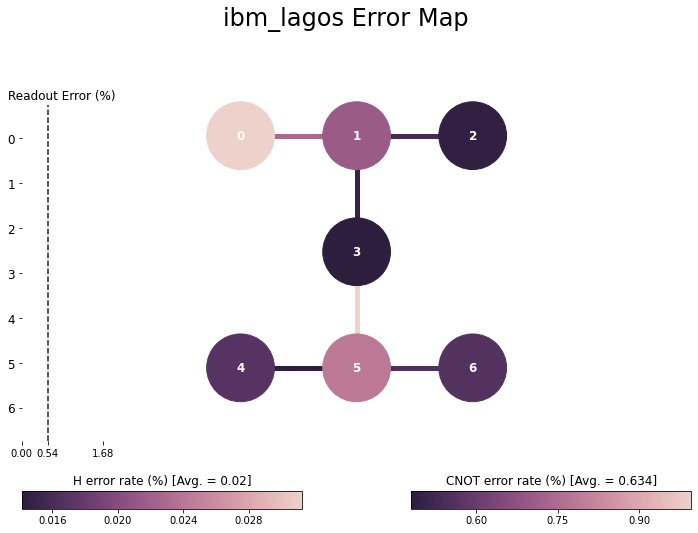

In [82]:
from qiskit.visualization import plot_gate_map, plot_error_map

plot_error_map(backend)

In [83]:
layout = [0,1,3,5]

The 'get_results' function has three methods for finding the results.

'matrix' $\rightarrow$ exact solution using matrix multiplication

'simulator' $\rightarrow$ approximate solution using the qasm simulator

'quantum' $\rightarrow$ using the quantum backend we loaded above.

The results are held in 'results'

## Running spin-down 

In [84]:
from qiskit import Aer
import copy

def get_results(circs_in, method = 'matrix',save_id_file = None):
    circs = copy.deepcopy(circs_in)
    #Exact Calculation
    if method == 'matrix':
        # add results
        r = []
        for l in range(len(circs)):
            circs[l].remove_final_measurements()
            wave = qi.Statevector.from_instruction(circs[l])
            r_l = wave.probabilities_dict()
            r.append(r_l)
    #Qiskit Simulation        
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        r = execute(circs, backend = sim).result().get_counts() 
    #Device
    if method == "quantum":
        job = backend.run(transpile(circs, backend,initial_layout = layout), meas_level=2, shots=8192)
        job_id = job.job_id()
        print(job_id)
        np.save(save_id_file,[job_id])
        r = job.result().get_counts()
    return r

results_triag = get_results(circs_triag)
results_square = get_results(circs_square)
#results = get_results(circs, method = 'simulator')

#save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/Gutzwiller/Data/Job_id_tria4"
#results = get_results(circs, method = 'quantum',save_id_file = save_id_file)

In [85]:
def normalize_results(results):
    results_out = []
    for result in results:
        result_out = {}
        states = list(result.keys())
        total = 0
        for state in states:
            total += result[state]
        for state in states:
            result_out[state] = result[state]/total
        results_out.append(result_out)
    return results_out
        
results_triag = normalize_results(results_triag)
results_square = normalize_results(results_square)

We can remove the states with zero weight and project out states with the wrong particle number

In [86]:
def relevent_states_chop(n,results):
    states_0 = list(results[0].keys())
    states = []
    for state in states_0:
        if results[0][state] > 10**(-2):
            ns = 0
            for i in range(len(state)):
                ns += int(state[i])
            if n == ns:
                states.append(state)
    return states

print( relevent_states_chop(2,results_square) )
#print( relevent_states_chop(2,loaded_results) )

['0011', '0101', '0110', '1001', '1100']


## Run spin-up alpha circuits

Now we run the unrotated circuit again for each relevent state $s$ in order to find $\alpha_s$.  The absolute value of $\alpha_s$ can be taken from the result we already have.  In order to find the phase of $\alpha_s$ we pick a reference state and then intefere each of the other states with the reference.  

If we use $|0011>$ as a reference state and we want to find the reletive phase of $|0101>$ then we can apply $(I + iX_1X_2)$

$$ (I + iX_1X_2)(\alpha_1|0011> + \alpha_2|0101>) = (\alpha_1 + i \alpha_2)|0011>  (\alpha_1 + i \alpha_2)|0101> $$

Taking the counts in |0011> gives
$$ |(\alpha_1 + i \alpha_2)|^2 = \alpha_1^2 + \alpha_1^2 + i \alpha_1\alpha_2^* - i \alpha_1^* \alpha_2  $$

If we write $\alpha_s = |\alpha_s|e^{i\phi_s}$ then we have
$$ |(\alpha_1 + i \alpha_2)|^2 - \alpha_1^2 - \alpha_1^2 = 2 |\alpha_1||\alpha_2|\sin(\phi_1-\phi_2) $$
and we can find the reletive phase by 
$$ \phi_1-\phi_2 = \sin^{-1}( \frac{|(\alpha_1 + i \alpha_2)|^2 - \alpha_1^2 - \alpha_1^2}{2i |\alpha_1||\alpha_2|} )$$

The only problem is that the arcsin function is not uniquely defined and so we want to do something similar except with an acrcoss.  To this end we apply $(I + iY_1X_2)$ as well.


In [87]:
def create_circ_nomeas(Fd,p_label):
    qbits = [0,1,2,3]
    qc = slatter_circ(Fd)
    psi = copy.deepcopy(qc)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)-1
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,qbits[Q-q])
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,qbits[Q-q])
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    return [psi,pauli_qs,p_label]

def r_xchain(circ_in,phi,xchain):
    N = len(xchain)
    circ = copy.deepcopy(circ_in)
    jl = []
    for i,P in enumerate(xchain):
        if P == 'X':
            jl.append(i)
    Nx = len(jl)
    jl = [N - 1 - jl[j] for j in range(Nx) ]
    for j in range(Nx-1):
        circ.cx(jl[Nx-2-j],jl[Nx-1-j])
    circ.rx(phi,jl[0])
    for j in range(Nx-1):
        circ.cx(jl[j],jl[j+1])
    return circ

def find_xchain(ref,state):
    op = ""
    for i in range(len(ref)):
        if ref[i] != state[i]:
            op = op + 'X'
        else:
            op = op + 'I'
    return op

def find_i0(xchain):
    N = len(xchain)
    for i,l in enumerate(xchain):
        if l == 'X':
            return N-1-i

def alpha_circ(circ,ref,state):
    xchain = find_xchain(ref,state)
    circx = r_xchain(circ,-np.pi/2,xchain) 
    circy = copy.deepcopy(circ)
    i0 = find_i0(xchain)
    #print(ref,state,xchain,i0)
    circy.rz(-np.pi/2,i0)
    circy = r_xchain(circy,-np.pi/2,xchain)  
    circy.rz(np.pi/2,i0)
    circx.measure(circx.qubits,circx.clbits)
    circy.measure(circy.qubits,circy.clbits)
    return [circx,circy]

def alpha_circs(circ,results):
    states = relevent_states_chop(2,results)
    ref = states[0]
    circ_out = []
    for s in range(1,len(states)):
        state = states[s]
        circxy = alpha_circ(circ,ref,state) 
        circ_out.append(circxy[0])
        circ_out.append(circxy[1])
    return circ_out

#Triangle lattice
circs = create_circ_nomeas(Fld('triangle',N),['ZZZZ'])
acircs_triag = alpha_circs(circs[0],results_triag) 
alpha_results_triag = get_results(acircs_triag)

#Square lattice
circs = create_circ_nomeas(Fld('square',N),['ZZZZ'])
acircs_square = alpha_circs(circs[0],results_square) 
alpha_results_square = get_results(acircs_square)


#alpha_results = get_results(acircs, method = 'simulator')

#save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/Gutzwiller/Data/Job_id_triag4_alphas"
#alpha_results = get_results(acircs, method = 'quantum',save_id_file = save_id_file)

# Analyzing the results

## Analyze alpha

In [88]:
def analyze_alphas(results,alpha_results):
    ref = relevent_states_chop(2,results)[0]
    alphas = [np.sqrt(results[0][ref])]
    for i in range(0,len(relevent_states_chop(2,results))-1):
        ref = relevent_states_chop(2,results)[0]
        state = relevent_states_chop(2,results)[i+1]
        a = results[0][ref]
        b = results[0][state]
        r2 = alpha_results[2*i]
        if ref in r2:
            phi_s = np.arcsin( np.clip( (2*r2[ref] - a - b)/np.sqrt(4*a*b), -1,1) )
        else:
            phi_s = np.arcsin( np.clip( (2*0 - a - b)/np.sqrt(4*a*b), -1,1) )
        r2 = alpha_results[2*i+1]
        if ref in r2:
            phi_c = np.arccos( np.clip( (2*r2[ref] - a - b)/np.sqrt(4*a*b), -1,1) )
        else:
            phi_c = np.arccos( np.clip( (2*0 - a - b)/np.sqrt(4*a*b), -1,1) )
        #print(state,phi_s,phi_c)
        alpha = (np.cos(phi_c) + 1j*np.sin(phi_s))*np.sqrt(b)/np.sqrt( (np.cos(phi_c)**2 + np.sin(phi_s)**2) )
        alphas.append(alpha)
    return alphas



In [89]:
analyze_alphas(results_square,alpha_results_square)

[0.3535533905932731,
 (-0.7071067811865476-1.2560739669470223e-15j),
 (0.3535533905932745-5.102800490722293e-16j),
 (0.35355339059327295-4.514015818715874e-16j),
 (-0.35355339059327445-4.710277376051335e-16j)]

In [90]:
-1j*alphas(Fl("square",N=4))

array([-0.00000000e+00+0.j, -0.00000000e+00+0.j, -0.00000000e+00+0.j,
        3.53553391e-01-0.j, -0.00000000e+00+0.j, -7.07106781e-01+0.j,
        3.53553391e-01-0.j, -0.00000000e+00+0.j, -0.00000000e+00+0.j,
        3.53553391e-01-0.j, -7.47694344e-33+0.j, -0.00000000e+00+0.j,
       -3.53553391e-01+0.j, -0.00000000e+00+0.j, -0.00000000e+00+0.j,
       -0.00000000e+00+0.j])

In [91]:
analyze_alphas(results_triag,alpha_results_triag)

[0.6123724356957948,
 (-0.20412414523193143-2.2662332591841964e-16j),
 (-0.6123724356957941+0j),
 (0.2041241452319312-1.5863632814289373e-16j),
 (0.40824829046386335-1.586363281428939e-16j)]

In [92]:
-1j*alphas(Fl("triangle",N=4))

array([-0.        +0.j, -0.        +0.j, -0.        +0.j, -0.        +0.j,
       -0.        +0.j,  0.61237244-0.j, -0.20412415+0.j, -0.        +0.j,
       -0.        +0.j, -0.61237244+0.j,  0.20412415-0.j, -0.        +0.j,
        0.40824829-0.j, -0.        +0.j, -0.        +0.j, -0.        +0.j])

## Analyze energy

We want to calculate 
$$E(g) = \frac{<\psi_0|\hat{G}\hat{H}\hat{G}|\psi_0>}{ <\psi_0|\hat{G}\hat{G}|\psi_0>  }$$
where $|\psi_0>$ is the slatter state which we have measured.  

In order to use the measurements we have taken to calculate $E(g)$ we will need to reference the spin up states and their weights.  The following three functions 'bi', 'up_states', and 'up_states_dic' help to reference the spin up states.

In [93]:
def bi(num,N):
    bi = bin(num)
    out = ""
    for i in range(2,len(bi)):
        out = out + bi[i]
    L = len(out)
    for i in range(L,N):
        out = "0"+out
    return out

################################# NEW ##############################
def up_states_new(results,alpha_results):
    out = []
    a = analyze_alphas(results,alpha_results)
    states = relevent_states_chop(2,results)
    for i in range(len(a)):
        out.append([states[i],a[i]])
    return out

def up_states_dic_new(results,alpha_results):
    out = {}
    a = analyze_alphas(results,alpha_results)
    states = relevent_states_chop(2,results)
    for i in range(len(a)):
        out[states[i]] = a[i]
    return out




Now we are ready to discuss how to analyze the results.  We need four brakets to calculate $E(g)$,
$$ <\psi_0|\hat{G}\hat{G}|\psi_0>, \quad <\psi_0|\hat{G}\hat{D}\hat{{G}}|\psi_0>, \quad <\psi_0|\hat{G}\hat{M}\hat{{G}}|\psi_0>, \quad <\psi_0|\hat{G}\hat{K}\hat{{G}}|\psi_0>. $$

The first three only require the measurement labeled 'ZZZZ' in 'paulis'.  In order to get these two brakets we simple need to check if the spin-up state and spin-down state have are both on for each index, result state, and spin-up state.  Let us refere to this value as $m_{irk}$ which is 1 if the spin-up state $k$ and the result state $r$ are both on at index $i$ and 0 otherwise.  

The normalization braket is
$$ <\psi_0|\hat{G}\hat{G}|\psi_0> = \sum_k |\alpha_k|^2\sum_r w_r \prod_i e^{-2m_{irk}g} $$

The second bracket is 
$$ <\psi_0|\hat{G}\hat{D}\hat{G}|\psi_0> = \sum_k |\alpha_k|^2\sum_r w_r \sum_p m_{prk}\prod_i e^{-2m_{irk}g} $$

The third bracket is
The second bracket is 
$$ <\psi_0|\hat{G}\hat{M}\hat{G}|\psi_0> = \sum_k |\alpha_k|^2\sum_r w_r N_{r}\prod_i e^{-2m_{irk}g} $$

The functions 'analyze_GG', 'analyze_GMG' and 'analyze_GDG' represent these three brakets.

where $w_r$ is the results for state $r$ and $\alpha_k$ is the weight of state $k$.

The last bracket requires all of the results.  The braket can be inferd from the result
$$ \hat{G}\hat{K}\hat{G} = \sum_{i=0}^{N-1}\sum_{\sigma}\prod_{j \neq i,i+1}e^{-2g n_{j\uparrow}n_{j\downarrow}} e^{-g n_{i\sigma+1}}e^{-g n_{i+1\sigma+1}}  \frac{k}{2}\left(X_{i\sigma}X_{i+1\sigma}+Y_{i+1\sigma}Y_{i\sigma}\right) $$

and the exact form of the braket is define below.  First we take the braket of each pauli term.  The spin-up Paulis need to be treaed seperately from the spin-down Paulis*.  Also the boundary term Paulis are treated seperetely from the bulk terms.  Finally, the function 'analyze_GKG' sums it all together. 

In [94]:


def analyze_GG(g,N,result,alpha_results):
    psi_up = up_states_new(results,alpha_results)
    r_keys = list(result.keys())
    gg = 0
    for k in range(len(psi_up)):
        s = psi_up[k][0]
        a = psi_up[k][1]
        for sr in r_keys:
            w = result[sr]
            gg_sr = 1
            for i in range(N):
                nu = int(s[i])
                nd = int(sr[i])
                gg_sr = gg_sr*np.exp(-2*g*nu*nd)
            gg = gg + np.conjugate(a)*a*w*gg_sr
    return gg


def analyze_GDG(g,d,N,result,alpha_results):
    psi_up = up_states_new(results,alpha_results)
    r_keys = list(result.keys())
    gg = 0
    for p in range(N):
        for k in range(len(psi_up)):
            s = psi_up[k][0]
            a = psi_up[k][1]
            for sr in r_keys:
                w = result[sr]
                gg_sr = 1
                for i in range(N):
                    nu = int(s[i])
                    nd = int(sr[i])
                    gg_sr = gg_sr*np.exp(-2*g*nu*nd)
                nu_p = int(s[p])
                nd_p = int(sr[p])
                gg_sr = d*gg_sr*nu_p*nd_p
                gg = gg + np.conjugate(a)*a*w*gg_sr
    return gg

   

def analyze_GMG(g,u,N,result,alpha_results):
    psi_up = up_states_new(results,alpha_results)
    r_keys = list(result.keys())
    gg = 0
    for p in range(N):
        for k in range(len(psi_up)):
            s = psi_up[k][0]
            a = psi_up[k][1]
            for sr in r_keys:
                w = result[sr]
                gg_sr = 1
                for i in range(N):
                    nu = int(s[i])
                    nd = int(sr[i])
                    gg_sr = gg_sr*np.exp(-2*g*nu*nd)
                nu_p = int(s[p])
                nd_p = int(sr[p])
                gg_sr = u*gg_sr*nd_p + u*gg_sr*nu_p  # changed nu_p to nd_p on the first term.  Did not seem to make a difference for the exect data but does for the quantum data.
                gg = gg + np.conjugate(a)*a*w*gg_sr
    return gg





In [95]:
def find_sset(pauli):
    sset = [i for i in range(len(pauli))] #Swapped set
    fset = []
    hset = []
    N=len(pauli)
    for i in range(len(pauli)-2):
        if pauli[i] == 'Z' or pauli[i] == 'I':
            fset.append(i)
    for i in range(len(pauli)-2,len(pauli)):
        if pauli[i] == 'X' or pauli[i] == 'Y':
                hset.append(i)
    for i in range(len(fset)):
        sset[hset[i]] = fset[i]
        sset[fset[i]] = hset[i]
    return sset

# Spin up is still in the original basis while spin down is in the swapped basis
def analyze_pd(g,pauli,paulis,results,alpha_results):
    sset = find_sset(pauli)
    idx = paulis.index(pauli)
    result = results[idx]
    states = ['0011','0101','1001','0110','1010','1100']
    alphas = up_states_dic_new(results,alpha_results)
    up_keys = list(alphas.keys())
    out = 0
    for state_up in up_keys:
        a = alphas[state_up]
        for state_down in states:
            w = result[state_down]
            z0 = 1
            z1 = 1
            if state_down[N-1] == '1':
                z0 = -1
            if state_down[N-2] == '1':
                z1 = -1
            gg_sr = 1
            for j in range(N):
                nu = int(state_up[N-1-sset[j]])
                nd = int(state_down[N-1-j])
                if j == 0 or j == 1:
                    gg_sr = gg_sr*np.exp(-g*nu)
                else:
                    gg_sr = gg_sr*np.exp(-2*g*nu*nd) 
            out = out + (z0- z1)*w*np.conjugate(a)*a*gg_sr
    return out


def analyze_pu(g,pauli,paulis,result,alpha_results):
    N=len(pauli)
    idxs = [i for i in range(4) if pauli[i] == 'X' or pauli[i] == 'Y']
    psi_up = up_states_dic_new(results,alpha_results)
    up_keys = list(psi_up.keys())
    r_keys = list(result.keys())
    gg = 0
    for su in up_keys:
        sup = list(su)
        sup[idxs[0]] = str(np.mod(int(sup[idxs[0]])+1,2) )
        sup[idxs[1]] = str(np.mod(int(sup[idxs[1]])+1,2) )
        sup = ''.join(sup)
        a = psi_up[su]
        if sup in psi_up:
            aa = psi_up[sup]
        else:
            aa = 0
        for sr in r_keys:
            w = result[sr]
            gg_sr = 1
            for j in range(N):
                nu = int(su[j])
                nd = int(sr[j])
                if pauli[j] == 'X':
                    gg_sr = gg_sr*np.exp(-g*nd)
                if pauli[j] == 'Y':
                    gg_sr = 1j*(-1)**int(su[j])*gg_sr*np.exp(-g*nd)
                elif pauli[j] == 'Z':
                    gg_sr = (-1)**nu*gg_sr*np.exp(-2*g*nu*nd)
                elif pauli[j] == 'I':
                    gg_sr = gg_sr*np.exp(-2*g*nu*nd)
            gg = gg + np.conjugate(aa)*a*w*gg_sr
    return gg

def analyze_GKG(g,k,N,paulis,results,alpha_results):
    out = 0
    for p in range(1,len(paulis)):
        out += k/2*analyze_pu(g,paulis[p],paulis,results[0],alpha_results)
        out += k/2*analyze_pd(g,paulis[p],paulis,results,alpha_results)/2
        #print(paulis[p],analyze_pd(g,paulis[p],paulis,paulis_new,results,alpha_results),analyze_pu(g,paulis[p],paulis,results[0],alpha_results))
    return out

In [96]:
results = results_triag
alpha_results = alpha_results_triag
paulis = paulis_triag
signs = signs_triag
paulis_new = paulis_new_triag
N=4
lattice = 'triangle'
F = Fl(lattice,N)
psi1 = Mdot([ad(3,F),ad(2,F),psi0(4)])
psi_spin = np.kron(psi1,psi1)
print( analyze_pd(1.2,'XZXI',paulis,results,alpha_results) - bkt(psi_spin,Mdot([G(1.2,4),X(0,8),Z(1,8),X(2,8),G(1.2,4)]),psi_spin) - bkt(psi_spin,Mdot([G(1.2,4),Y(0,8),Z(1,8),Y(2,8),G(1.2,4)]),psi_spin) )
print( analyze_pu(1.2,'IXZX',paulis,results[0],alpha_results) - Mdot([np.conjugate(psi_spin),G(1.2,4),X(4,8),Z(5,8),X(6,8),G(1.2,4),psi_spin]) )
print( analyze_GDG(1.3,2.1,4,results[0],alpha_results) -  Mdot([np.conjugate(psi_spin),G(1.3,4),D(2.1,4),G(1.3,4),psi_spin]) )
print( analyze_GG(1.3,4,results[0],alpha_results) - Mdot([np.conjugate(psi_spin),G(1.3,4),G(1.3,4),psi_spin]) )
print( analyze_GMG(1.3,2.1,4,results[0],alpha_results) -  Mdot([np.conjugate(psi_spin),G(1.3,4),M(2.1,4),G(1.3,4),psi_spin]) )
print( analyze_GKG(1.3,2.1,4,paulis,results,alpha_results) - Mdot([np.conjugate(psi_spin),G(1.3,4),K(2.1,lattice,N=N),G(1.3,4),psi_spin]) )


(-1.3877787807814457e-17+1.778757927768181e-33j)
(2.0816681711721685e-17-4.81482486096809e-34j)
(5.551115123125783e-17+0j)
(-1.249000902703301e-16+0j)
(-1.3322676295501878e-15+0j)
(5.551115123125783e-16+1.1557960589618893e-32j)


In [97]:
results = results_square
alpha_results = alpha_results_square
paulis = paulis_square
paulis_new = paulis_new_square
N=4
lattice = 'square'
F = Fl(lattice,N)
psi1 = Mdot([ad(3,F),ad(2,F),psi0(4)])
psi_spin = np.kron(psi1,psi1)
print( analyze_pd(1.2,'XXII',paulis,results,alpha_results) - bkt(psi_spin,Mdot([G(1.2,4),X(0,8),X(1,8),G(1.2,4)]),psi_spin) - bkt(psi_spin,Mdot([G(1.2,4),Y(0,8),Y(1,8),G(1.2,4)]),psi_spin) )
print( analyze_pu(1.2,'XXII',paulis,results[0],alpha_results) - Mdot([np.conjugate(psi_spin),G(1.2,4),X(2,8),X(3,8),G(1.2,4),psi_spin]) )

print( analyze_GDG(1.3,2.1,4,results[0],alpha_results) -  Mdot([np.conjugate(psi_spin),G(1.3,4),D(2.1,4),G(1.3,4),psi_spin]) )
print( analyze_GG(1.3,4,results[0],alpha_results) - Mdot([np.conjugate(psi_spin),G(1.3,4),G(1.3,4),psi_spin]) )
print( analyze_GMG(1.3,2.1,4,results[0],alpha_results) -  Mdot([np.conjugate(psi_spin),G(1.3,4),M(2.1,4),G(1.3,4),psi_spin]) )
print( analyze_GKG(1.3,2.1,4,paulis,results,alpha_results) - Mdot([np.conjugate(psi_spin),G(1.3,4),K(2.1,lattice,N=N),G(1.3,4),psi_spin]) )


(-1.1102230246251565e-16+4.740074059441967e-33j)
(-5.551115123125783e-17-9.244463733058732e-33j)
(2.3592239273284576e-16+0j)
(2.7755575615628914e-16+0j)
(2.7755575615628914e-15+0j)
(-1.2212453270876722e-15-1.1548701962047795e-32j)


In [98]:
def analyze_energy(g,u,k,d,N,paulis,results,alpha_results):
    num = analyze_GMG(g,u,N,results[0],alpha_results) +analyze_GDG(g,d,N,results[0],alpha_results) + analyze_GKG(g,k,N,paulis,results,alpha_results)
    dom = analyze_GG(g,N,results[0],alpha_results)
    return num/dom

In [99]:
#square
results = results_square
alpha_results = alpha_results_square
paulis = paulis_square
N=4
lattice = 'square'
F = Fl(lattice,N)
psi1 = Mdot([ad(3,F),ad(2,F),psi0(4)])
psi_spin = np.kron(psi1,psi1)

u = -2
k = 1
d = 1.5
N=4
H = M(u,4) + K(k,lattice,N) + D(d,4)
bkt(psi_spin,H,psi_spin) - analyze_energy(0,u,k,d,N,paulis,results,alpha_results)

(1.5987211554602254e-14-2.4651903288156613e-32j)

In [100]:
#Triangle
results = results_triag
alpha_results = alpha_results_triag
paulis = paulis_triag
N=4
lattice = 'triangle'
F = Fl(lattice,N)
psi1 = Mdot([ad(3,F),ad(2,F),psi0(4)])
psi_spin = np.kron(psi1,psi1)

u = -2
k = 1
d = 1.5
N=4
H = M(u,4) + K(k,lattice,N) + D(d,4)
bkt(psi_spin,H,psi_spin) - analyze_energy(0,u,k,d,N,paulis,results,alpha_results)

(5.329070518200751e-15-2.7925984193615043e-33j)

# Running Scans

With everything in order we can now run scans of $E(g)$.

## Square Lattice

In [101]:
#square
results = results_square
alpha_results = alpha_results_square
paulis = paulis_square
N=4
lattice = 'square'
F = Fl(lattice,N)
psi1 = Mdot([ad(3,F),ad(2,F),psi0(4)])
psi_spin = np.kron(psi1,psi1)

#parameters
u = 0
k = 1
d = 0
N=4

#Exact Eigenvalue
H = M(u,4) + K(k,lattice,N=N) + D(d,4)
e,y = np.linalg.eig(H)
y = np.transpose(y)
arg = np.argsort(e)

#Scan
eg = []
gl = []
eT = []
for gi in range(-10,10):
    g = gi
    egl = analyze_energy(g,u,k,d,N,paulis,results,alpha_results)
    eg.append(egl)
    gl.append(g)
    eT.append(e[arg[[0]]])

/opt/miniconda3/envs/qiskit_3.5/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


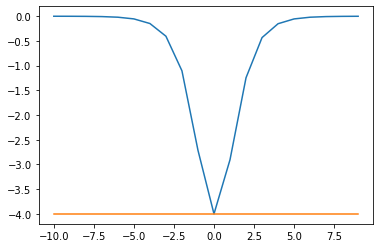

In [102]:
import matplotlib.pyplot as plt

plt.plot(gl,eg)
#plt.plot(gl,eg_h)
plt.plot(gl,eT)

## Triangulare lattice

In [103]:
#Triangle
results = results_triag
alpha_results = alpha_results_triag
paulis = paulis_triag
N=4
lattice = 'triangle'
F = Fl(lattice,N)
psi1 = Mdot([ad(3,F),ad(2,F),psi0(4)])
psi_spin = np.kron(psi1,psi1)

#parameters
u = 1
k = 1
d = 0
N=4

#Exact Eigenvalue
H = M(u,4) + K(k,lattice,N=N) + D(d,4)
e,y = np.linalg.eig(H)
y = np.transpose(y)
arg = np.argsort(e)

#Scan
eg = []
gl = []
eT = []
for gi in range(-10,10):
    g = gi
    egl = analyze_energy(g,u,k,d,N,paulis,results,alpha_results)
    eg.append(egl)
    gl.append(g)
    eT.append(e[arg[[0]]])

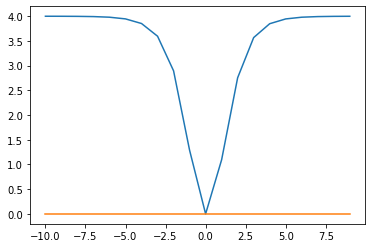

In [104]:
import matplotlib.pyplot as plt

plt.plot(gl,eg)
#plt.plot(gl,eg_h)
plt.plot(gl,eT)